In [1]:
import time
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [23]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) 
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        it.iternext()   
        
    return grad

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    return np.exp(x) / np.sum(np.exp(x))

In [5]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [6]:
def one_hot_encoding(label):
    #首先創建row=label,col=10的零矩陣，用於下面encoding
    T = np.zeros((label.size, 10)) #注意是要創建二維矩陣，所以這裡要用雙括號!!
    for i, row_i in enumerate(T):
        row_i[label[i]] = 1 #將label[i]對應到row_i的label(圖形的正確答案)設為1(one hot encoding)
    
    return T

In [39]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
            
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    def loss(self, x, t):
        y = self.predict(x)
            
        return cross_entropy_error(y, t)
        
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) #回傳最大值的位置
        t = np.argmax(t, axis=1)
            
        accuracy = np.sum(y==t) / float(x.shape[0])
            
        return accuracy
        
    def numerical_gradient(self, x, t):
        loss_func = lambda W: self.loss(x, t)
            
        grad = {}
        grad['W1'] = numerical_gradient(loss_func, self.params['W1'])
        grad['b1'] = numerical_gradient(loss_func, self.params['b1'])
        grad['W2'] = numerical_gradient(loss_func, self.params['W2'])
        grad['b2'] = numerical_gradient(loss_func, self.params['b2'])
            
        return grad

In [40]:
(feature_train, label_train), (feature_test, label_test) = mnist.load_data()

Normalize the feature and label one hot encoding

In [41]:
feature_train_flat = feature_train.reshape(len(feature_train),784).astype('float32')
feature_test_flat = feature_test.reshape(len(feature_test),784).astype('float32')

In [42]:
feature_train_normalize = feature_train_flat / 225
feature_test_normalize = feature_test_flat / 225

In [43]:
label_train_encoding = one_hot_encoding(label_train)
label_test_encoding = one_hot_encoding(label_test)

In [51]:
t, t_min, t_hr = 0, 0 , 0
loss_list= []
iter_num = 6000 
train_size = feature_train_normalize.shape[0] #以shape[0]調用訓練組的總數量，這裡也可以用len()
batch_size = 100
lr = 0.1 # learning rate

iter_per_epoch = max(train_size / batch_size, 1)
train_accuracy_list = [] 
test_accuracy_list = []

In [53]:
network = TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

In [54]:
for i in range(iter_num):
    t_start = time.time()
    
    batch_mask = np.random.choice(train_size, batch_size) #從訓練總量(60000)隨機梯挑選100組數字放入array
    x_batch = feature_train_normalize[batch_mask] #從訓練組找出mask隨機挑選出的訓練資料
    t_batch = label_train_encoding[batch_mask] #原理同上
    
    grad = network.numerical_gradient(x_batch, t_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= lr * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    loss_list.append(loss)
    
    t_end = time.time()
    t_min = (t_end - t_start) / 60
    t_hr += t_min / 60
    print('第 %d 次批次學習，時間: %f 分鐘，總共花費: %f 小時' %(i, t_min, t_hr))

    if i % (iter_per_epoch / 100) == 0: #控制epoch縮小100倍
        train_accuracy = network.accuracy(feature_train_normalize, label_train_encoding)
        test_accuracy = network.accuracy(feature_test_normalize, label_test_encoding)
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)


第 0 次批次學習，時間: 2.290371 分鐘，總共花費: 0.038173 小時
第 1 次批次學習，時間: 2.537687 分鐘，總共花費: 0.080468 小時
第 2 次批次學習，時間: 2.400437 分鐘，總共花費: 0.120475 小時
第 3 次批次學習，時間: 2.436477 分鐘，總共花費: 0.161083 小時
第 4 次批次學習，時間: 2.416352 分鐘，總共花費: 0.201355 小時
第 5 次批次學習，時間: 2.404306 分鐘，總共花費: 0.241427 小時
第 6 次批次學習，時間: 2.440311 分鐘，總共花費: 0.282099 小時
第 7 次批次學習，時間: 2.409357 分鐘，總共花費: 0.322255 小時
第 8 次批次學習，時間: 2.498750 分鐘，總共花費: 0.363901 小時
第 9 次批次學習，時間: 2.425291 分鐘，總共花費: 0.404322 小時
第 10 次批次學習，時間: 2.407116 分鐘，總共花費: 0.444441 小時
第 11 次批次學習，時間: 2.314347 分鐘，總共花費: 0.483013 小時
第 12 次批次學習，時間: 2.334791 分鐘，總共花費: 0.521927 小時
第 13 次批次學習，時間: 2.374414 分鐘，總共花費: 0.561500 小時
第 14 次批次學習，時間: 2.440788 分鐘，總共花費: 0.602180 小時
第 15 次批次學習，時間: 2.323186 分鐘，總共花費: 0.640900 小時
第 16 次批次學習，時間: 2.312886 分鐘，總共花費: 0.679448 小時
第 17 次批次學習，時間: 2.318853 分鐘，總共花費: 0.718095 小時
第 18 次批次學習，時間: 2.337367 分鐘，總共花費: 0.757051 小時
第 19 次批次學習，時間: 2.454821 分鐘，總共花費: 0.797965 小時
第 20 次批次學習，時間: 2.323015 分鐘，總共花費: 0.836682 小時
第 21 次批次學習，時間: 2.408980 分鐘，總共花費: 0.876832 小時
第 22 次批次學習，時間: 2.327

第 181 次批次學習，時間: 2.245213 分鐘，總共花費: 7.424161 小時
第 182 次批次學習，時間: 2.180726 分鐘，總共花費: 7.460506 小時
第 183 次批次學習，時間: 2.188577 分鐘，總共花費: 7.496983 小時
第 184 次批次學習，時間: 2.165694 分鐘，總共花費: 7.533078 小時
第 185 次批次學習，時間: 2.304396 分鐘，總共花費: 7.571484 小時
第 186 次批次學習，時間: 2.165329 分鐘，總共花費: 7.607573 小時
第 187 次批次學習，時間: 2.162595 分鐘，總共花費: 7.643616 小時
第 188 次批次學習，時間: 2.162607 分鐘，總共花費: 7.679660 小時
第 189 次批次學習，時間: 2.170264 分鐘，總共花費: 7.715831 小時
第 190 次批次學習，時間: 2.160528 分鐘，總共花費: 7.751840 小時
第 191 次批次學習，時間: 2.163683 分鐘，總共花費: 7.787901 小時
第 192 次批次學習，時間: 2.251363 分鐘，總共花費: 7.825424 小時
第 193 次批次學習，時間: 2.158168 分鐘，總共花費: 7.861393 小時
第 194 次批次學習，時間: 2.162153 分鐘，總共花費: 7.897429 小時
第 195 次批次學習，時間: 2.263704 分鐘，總共花費: 7.935157 小時
第 196 次批次學習，時間: 2.156409 分鐘，總共花費: 7.971098 小時
第 197 次批次學習，時間: 2.164744 分鐘，總共花費: 8.007177 小時
第 198 次批次學習，時間: 2.226138 分鐘，總共花費: 8.044279 小時
第 199 次批次學習，時間: 2.193127 分鐘，總共花費: 8.080831 小時
第 200 次批次學習，時間: 2.163039 分鐘，總共花費: 8.116882 小時
第 201 次批次學習，時間: 2.163932 分鐘，總共花費: 8.152947 小時
第 202 次批次學習，時間: 2.175949 分鐘，總共花費: 

第 357 次批次學習，時間: 2.267694 分鐘，總共花費: 13.869124 小時
第 358 次批次學習，時間: 2.341250 分鐘，總共花費: 13.908144 小時
第 359 次批次學習，時間: 2.161332 分鐘，總共花費: 13.944167 小時
第 360 次批次學習，時間: 2.139838 分鐘，總共花費: 13.979831 小時
第 361 次批次學習，時間: 2.144619 分鐘，總共花費: 14.015574 小時
第 362 次批次學習，時間: 2.154621 分鐘，總共花費: 14.051485 小時
第 363 次批次學習，時間: 2.126637 分鐘，總共花費: 14.086929 小時
第 364 次批次學習，時間: 2.152415 分鐘，總共花費: 14.122802 小時
第 365 次批次學習，時間: 2.145459 分鐘，總共花費: 14.158560 小時
第 366 次批次學習，時間: 2.140109 分鐘，總共花費: 14.194228 小時
第 367 次批次學習，時間: 2.160391 分鐘，總共花費: 14.230235 小時
第 368 次批次學習，時間: 2.166051 分鐘，總共花費: 14.266336 小時
第 369 次批次學習，時間: 2.137752 分鐘，總共花費: 14.301965 小時
第 370 次批次學習，時間: 2.147360 分鐘，總共花費: 14.337754 小時
第 371 次批次學習，時間: 2.151049 分鐘，總共花費: 14.373605 小時
第 372 次批次學習，時間: 2.150754 分鐘，總共花費: 14.409451 小時
第 373 次批次學習，時間: 2.144507 分鐘，總共花費: 14.445193 小時
第 374 次批次學習，時間: 2.163188 分鐘，總共花費: 14.481246 小時
第 375 次批次學習，時間: 2.145280 分鐘，總共花費: 14.517000 小時
第 376 次批次學習，時間: 2.302615 分鐘，總共花費: 14.555377 小時
第 377 次批次學習，時間: 2.140910 分鐘，總共花費: 14.591059 小時
第 378 次批次學習，時

第 532 次批次學習，時間: 2.214269 分鐘，總共花費: 20.222759 小時
第 533 次批次學習，時間: 2.243846 分鐘，總共花費: 20.260156 小時
第 534 次批次學習，時間: 2.217701 分鐘，總共花費: 20.297118 小時
第 535 次批次學習，時間: 2.225998 分鐘，總共花費: 20.334218 小時
第 536 次批次學習，時間: 2.223622 分鐘，總共花費: 20.371278 小時
第 537 次批次學習，時間: 2.213121 分鐘，總共花費: 20.408163 小時
第 538 次批次學習，時間: 2.195863 分鐘，總共花費: 20.444761 小時
第 539 次批次學習，時間: 2.212455 分鐘，總共花費: 20.481635 小時
第 540 次批次學習，時間: 2.214715 分鐘，總共花費: 20.518547 小時
第 541 次批次學習，時間: 2.348569 分鐘，總共花費: 20.557690 小時
第 542 次批次學習，時間: 2.204977 分鐘，總共花費: 20.594440 小時
第 543 次批次學習，時間: 2.206688 分鐘，總共花費: 20.631218 小時
第 544 次批次學習，時間: 2.223728 分鐘，總共花費: 20.668280 小時
第 545 次批次學習，時間: 2.207660 分鐘，總共花費: 20.705074 小時
第 546 次批次學習，時間: 2.224493 分鐘，總共花費: 20.742149 小時
第 547 次批次學習，時間: 2.230355 分鐘，總共花費: 20.779322 小時
第 548 次批次學習，時間: 2.227007 分鐘，總共花費: 20.816438 小時
第 549 次批次學習，時間: 2.208166 分鐘，總共花費: 20.853241 小時
第 550 次批次學習，時間: 2.423212 分鐘，總共花費: 20.893628 小時
第 551 次批次學習，時間: 2.217552 分鐘，總共花費: 20.930587 小時
第 552 次批次學習，時間: 2.248012 分鐘，總共花費: 20.968054 小時
第 553 次批次學習，時

第 707 次批次學習，時間: 2.295008 分鐘，總共花費: 26.943150 小時
第 708 次批次學習，時間: 2.311900 分鐘，總共花費: 26.981681 小時
第 709 次批次學習，時間: 2.295863 分鐘，總共花費: 27.019946 小時
第 710 次批次學習，時間: 2.287677 分鐘，總共花費: 27.058074 小時
第 711 次批次學習，時間: 2.302081 分鐘，總共花費: 27.096442 小時
第 712 次批次學習，時間: 2.293329 分鐘，總共花費: 27.134664 小時
第 713 次批次學習，時間: 2.286444 分鐘，總共花費: 27.172771 小時
第 714 次批次學習，時間: 2.287740 分鐘，總共花費: 27.210900 小時
第 715 次批次學習，時間: 2.288511 分鐘，總共花費: 27.249042 小時
第 716 次批次學習，時間: 2.308154 分鐘，總共花費: 27.287511 小時
第 717 次批次學習，時間: 2.258737 分鐘，總共花費: 27.325157 小時
第 718 次批次學習，時間: 2.306148 分鐘，總共花費: 27.363593 小時
第 719 次批次學習，時間: 2.259037 分鐘，總共花費: 27.401244 小時
第 720 次批次學習，時間: 2.272174 分鐘，總共花費: 27.439113 小時
第 721 次批次學習，時間: 2.282108 分鐘，總共花費: 27.477148 小時
第 722 次批次學習，時間: 2.592111 分鐘，總共花費: 27.520350 小時
第 723 次批次學習，時間: 2.402599 分鐘，總共花費: 27.560393 小時
第 724 次批次學習，時間: 2.405289 分鐘，總共花費: 27.600482 小時
第 725 次批次學習，時間: 2.395508 分鐘，總共花費: 27.640407 小時
第 726 次批次學習，時間: 2.415982 分鐘，總共花費: 27.680673 小時
第 727 次批次學習，時間: 2.719079 分鐘，總共花費: 27.725991 小時
第 728 次批次學習，時

KeyboardInterrupt: 

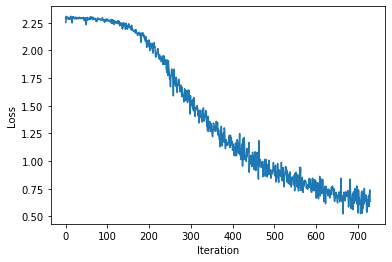

In [56]:
x = np.arange(len(loss_list))
plt.plot(x, loss_list)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

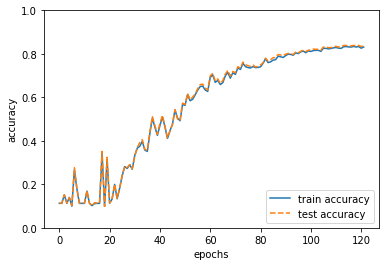

In [57]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_accuracy_list))
plt.plot(x, train_accuracy_list, label='train accuracy')
plt.plot(x, test_accuracy_list, label='test accuracy', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()